In [137]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
import time, glob
import numpy as np

def convert_to_nv21(file_name):
  img_bgr = cv2.imread(file_name)

  # Convert to YUV420
  H, W = img_bgr.shape[:2]
  img_bgr = img_bgr[0:H-H%2, 0:W-W%2]
  yuv_i420 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV_I420).flatten()
  height, width = img_bgr.shape[:2]

  # NV21 Downsample by 2
  y_plane_size = width * height
  uv_plane_size = y_plane_size//4

  # Retrieving Y, U and V
  y = yuv_i420[0:y_plane_size]
  v = yuv_i420[y_plane_size+uv_plane_size:]
  u = yuv_i420[y_plane_size:y_plane_size+uv_plane_size]

  # Interleave V and U to form the NV21
  vu = np.stack((v, u), axis=1).reshape(-1)

  # Concatenate Y and interleaved VU
  nv21 = np.concatenate((y, vu))

  return nv21, width, height

def plot_nv21_image(nv21_array, width, height):
  # Convert NV21 byte array to numpy array
  nv21 = np.array(nv21_array, dtype=np.uint8)

  # Reshape the array to match the dimensions of the NV21 format
  yuv = nv21.reshape((height * 3 // 2, width))

  # Convert the NV21 (YUV420sp) format to BGR (which OpenCV uses)
  bgr_image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR_NV21)

  # Convert BGR to RGB for displaying with matplotlib
  rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

  return rgb_image

def readImageDat(dfil, show=True):
    with open(dfil) as f:
        txt = f.readlines()
    ntxt = [float(x) for x in txt[0].split(',')]
    W, H = map(int, ntxt[:2])
    nd = ntxt[2:W*H+2]
    img = np.reshape(nd,(W,H),'F').T
    # print(np.unique(img), img.shape)
    if show:
        plt.figure()
        plt.imshow(img)
        plt.colorbar()
    return img

### From PNG get NV21 data and write out as .dat file

In [ ]:
nv21, w, h = convert_to_nv21('tests/ex1.png')
with open('tests/ex1.dat','w') as f:
    f.write('%d,%d,'%(w,h));
    f.write(','.join(['%d'%x for x in nv21]))

In [66]:
fils = glob.glob('tests/*.png')
fils = ['tests/exTough/tough_019.png']
for fil in fils:
    nv21, w, h = convert_to_nv21(fil)
    print(w,h)
    with open(fil.replace('.png','.dat'),'w') as f:
        f.write('%d,%d,'%(w,h));
        f.write(','.join(['%d'%x for x in nv21]))

136 108


In [64]:
dfil = 'tests/exTough/tough_019.dat'
with open(dfil) as f:
    txt = f.readlines()
    ntxt = [float(x) for x in txt[0].split(',')]
    

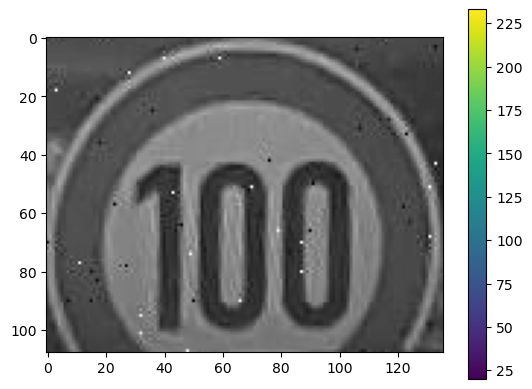

In [80]:
img = readImageDat(dfil)
plt.imshow(img,cmap='gray')

### After running the C++ code (>./a.out 1 tests/ex1.dat) visualize the flat data 

total pixels= 3528


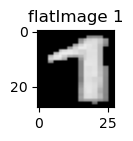

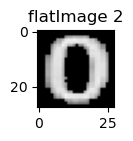

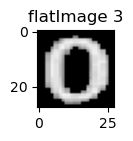

In [145]:
with open('tests/flatImages.out','r') as f:
    txt = f.readlines()
dat = [int(x) for x in txt[0].strip().strip(',').split(',')]
print('total pixels=',len(dat))

w = 28
h = 28
isz = int(w*h*1.5)
noff = 0
ncnt = 0
imgs = []
while(noff<len(dat)):
    idat = dat[noff:noff+isz]
    ncnt += 1
    noff+= isz
    idat = np.reshape(idat,(int(h*1.5),w),'C')
    rgb = plot_nv21_image(idat,w,h)
    imgs.append(rgb)
    plt.figure(figsize=(1,1))
    plt.imshow(rgb)
    plt.title('flatImage %d'%ncnt)

[8.7339467e-27 2.9764730e-03 2.3350546e-13 2.6976266e-16 1.3065635e-24
 1.2024962e-33 1.1948651e-32 0.0000000e+00 3.2666333e-38 0.0000000e+00
 9.9702352e-01]
[9.9992073e-01 1.8661165e-24 3.9939409e-14 1.7378677e-23 4.0722260e-25
 2.6107307e-15 4.3855262e-09 4.0532007e-22 1.5059266e-17 3.3761026e-14
 7.9213096e-05]
[5.18000743e-04 7.30545732e-22 3.13294864e-18 8.17691626e-23
 2.56157439e-21 3.60932200e-16 1.88510141e-09 1.03049154e-26
 6.90702532e-20 2.92741522e-16 9.99481976e-01]


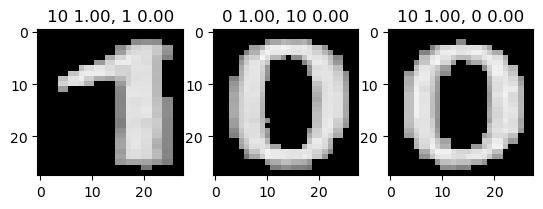

In [146]:
import numpy as np
with open('tests/probas.dat','w') as f:
    f.write('%d,%d'%(len(imgs),11))
    for nimg, timg in enumerate(imgs):
        # cv2.imwrite()
        x = tf.keras.utils.img_to_array(timg[:,:,:1].astype(float))
        x = x[tf.newaxis,...]
        out = infer(tf.constant(x))
        pb = np.array(out['dense_1'])[0]
        for nn in range(11):
            f.write(",%e"%pb[nn]);
        plt.subplot(1,3,nimg+1)
        plt.imshow(timg)
        print(pb)
        label = np.argsort(pb*-1)
        plt.title('%d %1.2f, %d %1.2f'%(label[0], pb[label[0]], label[1], pb[label[1]]))

In [93]:
pb

array([1.2892699e-13, 9.9618214e-01, 1.7739120e-07, 1.2727794e-10,
       7.4181590e-21, 5.1228408e-32, 1.0531097e-15, 2.2238708e-14,
       9.1709316e-15, 1.2434794e-08, 3.8176510e-03], dtype=float32)

In [32]:
import tensorflow as tf 
m = tf.saved_model.load('DLModel')
infer = m.signatures["serving_default"]

In [28]:
label

array([10,  0,  6,  1,  9,  5,  2,  8,  4,  3,  7], dtype=int64)

### Additional outputs

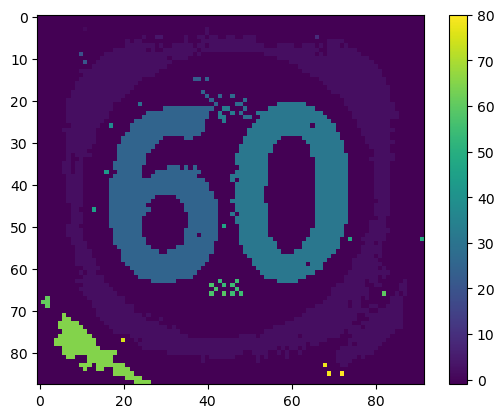

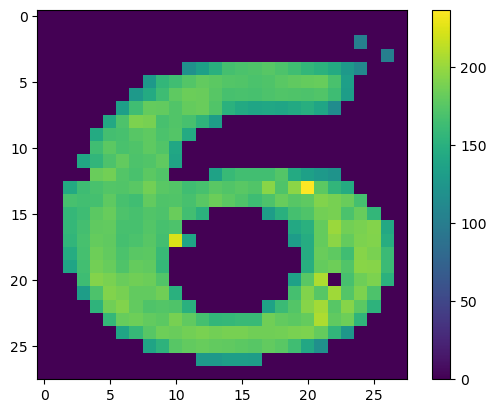

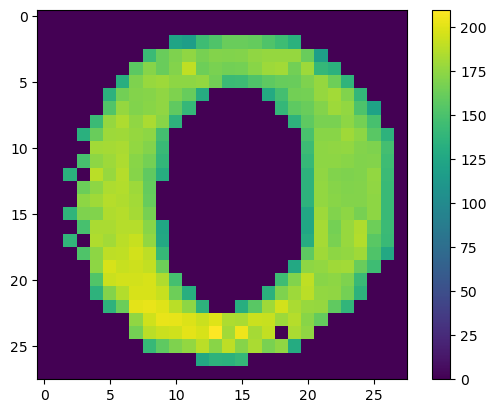

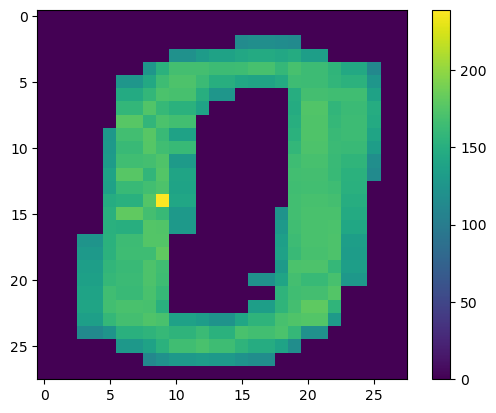

In [142]:
import glob
fils = glob.glob('tests/label*.out')
for dfil in fils:
    if (dfil.find('flat')>=0):
        continue
    readImageDat(dfil)
